In [1]:
import os
import tqdm
import pathlib
import numpy as np
import pandas as pd
import keras
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error,r2_score
from sklearn import preprocessing
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import shap
import keras.backend as K

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
df = pd.read_csv('df_result_1.csv')
df.head()

,Unnamed: 0,NP size_min,NP size_max,NP size_avg,ZOI_drug,ZOI_drug_NP,NumHDonors,NumHAcceptors,MaxAbsPartialCharge,MinAbsPartialCharge,MinPartialCharge,"avg_Incub_period, h","growth_temp, C",biosafety_level,shape_nanorods_and_triangles,gram_p
0,0,4.0,10.0,8.0,17.0,32.0,4.0,6.0,0.507967,0.327399,-0.507967,84.0,37.0,2.0,0.0,0
1,1,4.0,10.0,8.0,17.0,32.0,1.0,5.0,1.000000,0.547832,-0.547832,84.0,37.0,2.0,0.0,0
2,2,15.0,30.0,28.0,17.0,32.0,4.0,6.0,0.507967,0.327399,-0.507967,84.0,37.0,2.0,0.0,0
3,3,15.0,30.0,28.0,17.0,32.0,1.0,5.0,1.000000,0.547832,-0.547832,84.0,37.0,2.0,0.0,0
4,4,5.0,30.0,21.0,0.0,17.0,19.0,25.0,0.507810,0.330441,-0.507810,288.0,30.0,1.0,0.0,1


In [3]:
df.drop('Unnamed: 0',axis = 1)

,NP size_min,NP size_max,NP size_avg,ZOI_drug,ZOI_drug_NP,NumHDonors,NumHAcceptors,MaxAbsPartialCharge,MinAbsPartialCharge,MinPartialCharge,"avg_Incub_period, h","growth_temp, C",biosafety_level,shape_nanorods_and_triangles,gram_p
0,4.0,10.0,8.0,17.0000,32.000,4.0,6.0,0.507967,0.327399,-0.507967,84.0,37.0,2.0,0.0,0
1,4.0,10.0,8.0,17.0000,32.000,1.0,5.0,1.000000,0.547832,-0.547832,84.0,37.0,2.0,0.0,0
2,15.0,30.0,28.0,17.0000,32.000,4.0,6.0,0.507967,0.327399,-0.507967,84.0,37.0,2.0,0.0,0
3,15.0,30.0,28.0,17.0000,32.000,1.0,5.0,1.000000,0.547832,-0.547832,84.0,37.0,2.0,0.0,0
4,5.0,30.0,21.0,0.0000,17.000,19.0,25.0,0.507810,0.330441,-0.507810,288.0,30.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,4.0,10.0,8.0,1.0000,0.125,4.0,6.0,0.507967,0.327399,-0.507967,36.0,37.0,2.0,0.0,1
531,5.0,80.0,60.0,0.3125,0.100,4.0,6.0,0.507967,0.327399,-0.507967,18.0,37.0,2.0,0.0,0
532,4.0,10.0,8.0,0.0300,0.030,8.0,12.0,0.387562,0.185232,-0.387562,36.0,37.0,2.0,0.0,1
533,15.0,30.0,28.0,0.0300,0.030,8.0,12.0,0.387562,0.185232,-0.387562,48.0,37.0,2.0,0.0,0


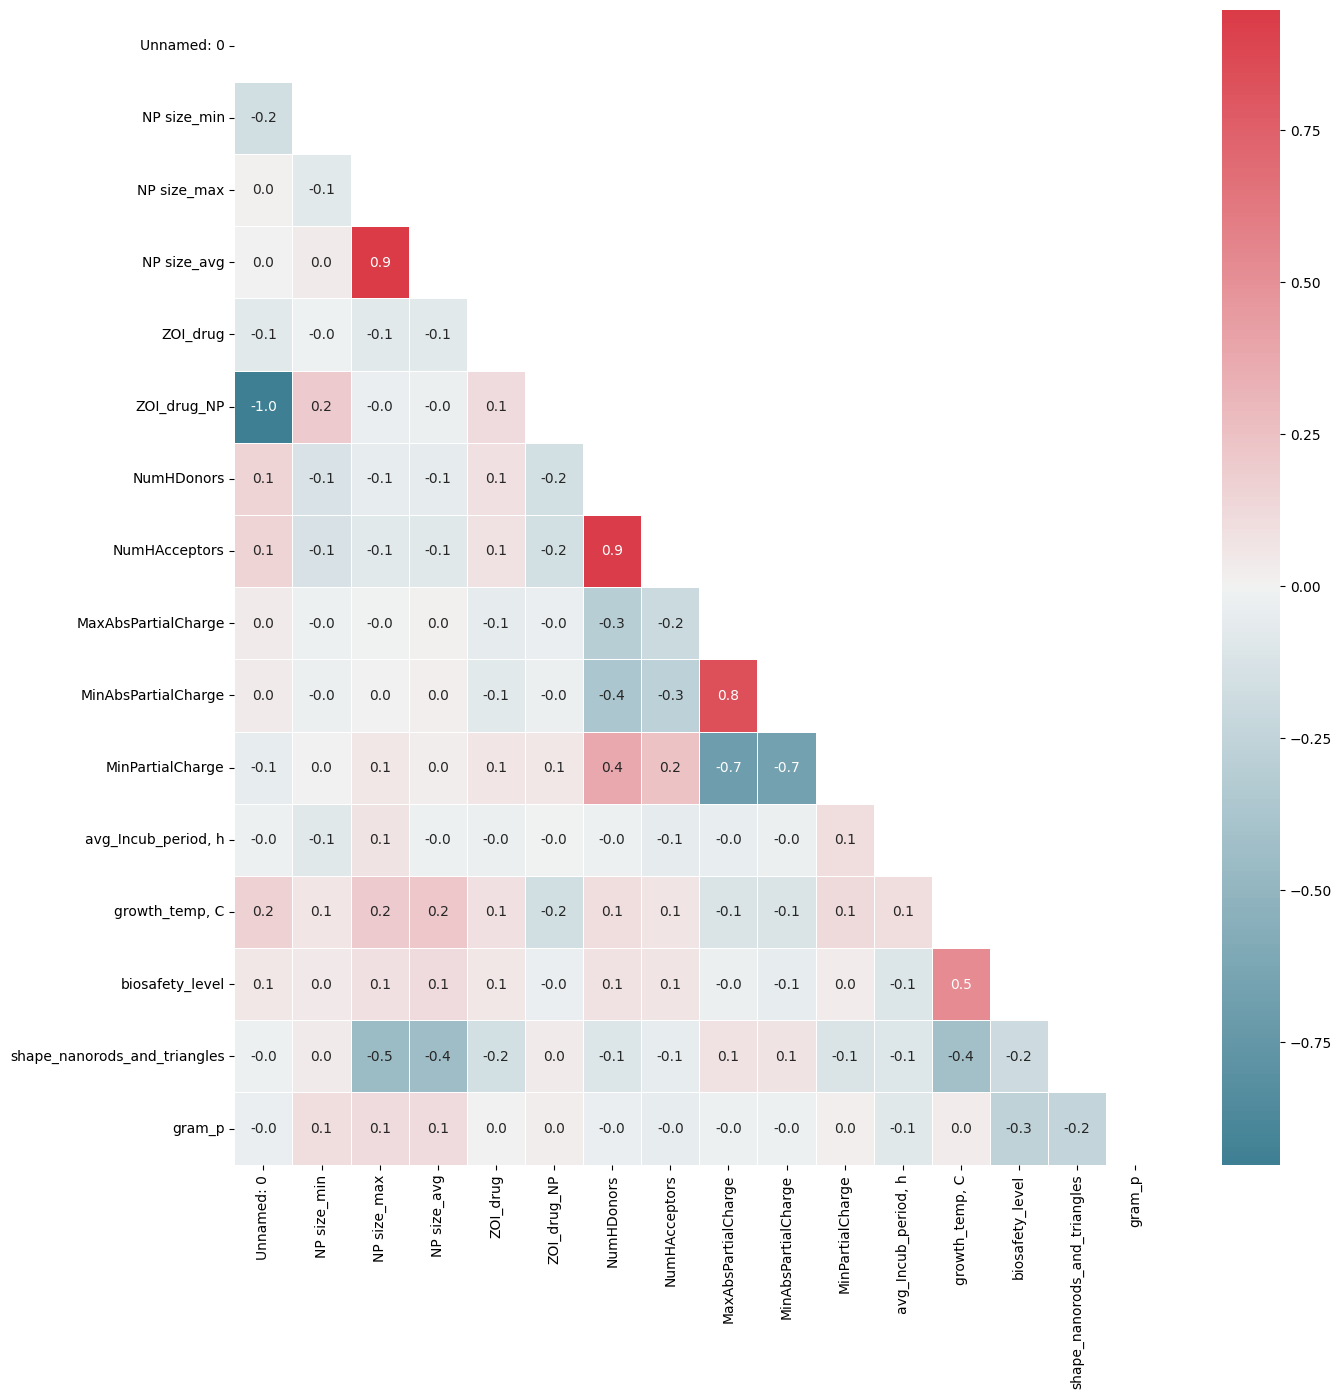

In [4]:
corr1 = df.corr()
mask = np.zeros_like(corr1, dtype=bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(15, 15)) #создание графика и определение его размеров
cmap = sns.diverging_palette(220, 10, as_cmap=True) #создание палитры для корреляционного графика
sns.heatmap(corr1, cmap=cmap, linewidths=.5, mask=mask, annot=True, fmt=".1f") 
plt.show()

In [5]:
df = df[df['ZOI_drug_NP'] > 0.001]

In [6]:
print(df[df['ZOI_drug']>= 60].shape)
df = df[df['ZOI_drug'] < 60]
df = df[df['ZOI_drug'] > 0]

(21, 16)


In [7]:
X = ['NP size_min', 'NP size_max', 'NP size_avg', 'ZOI_drug', 'NumHDonors',
     'NumHAcceptors', 'MaxAbsPartialCharge','MinAbsPartialCharge', 'MinPartialCharge', 'avg_Incub_period, h','growth_temp, C', 'shape_nanorods_and_triangles','gram_p','biosafety_level']
y = ['ZOI_drug_NP']

In [8]:
train, test = train_test_split(df,random_state=20032003)

In [9]:
X_valid = test[X]
y_valid = test[y]
X_train = train[X]
y_train = train[y]

In [10]:
earlystop_callb = EarlyStopping(monitor='val_mape',
                                patience=32,
                                )
checkpoint_callb = ModelCheckpoint(filepath='model_targ0.h5',
                                   monitor='val_mape',
                                   save_best_only=True)

reducelr_callb = ReduceLROnPlateau(monitor = 'val_mape', 
                                   factor=0.1,
                                   patience=30,
                                   verbose=1)

checkpoint_callb1 = ModelCheckpoint(filepath='model_targ1.h5',
                                   monitor='val_mape',
                                   save_best_only=True)

In [11]:
inp1 = Input(shape=(14,))

x1 = Dense(256, activation='relu')(inp1)
x1 = Dense(128, activation='relu')(x1)
x1 = Dense(128, activation='relu')(x1)
x1 = Dense(64, activation='relu')(x1)
x1 = Dense(1, activation='linear', name='targ0')(x1)

model_one_targ0 = Model(inp1, x1)

model_one_targ0.compile(optimizer=Adam(0.001), loss='mse', metrics=['mape'])

model_one_targ0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14)]              0         
                                                                 
 dense (Dense)               (None, 256)               3840      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 targ0 (Dense)               (None, 1)                 65        
                                                                 
Total params: 61,569
Trainable params: 61,569
Non-trainable p

In [12]:
history = model_one_targ0.fit(X_train, 
                              y_train, 
                              epochs=1000, 
                              batch_size=16, 
                              validation_data=(X_valid, y_valid),
                              callbacks=[reducelr_callb,
                                         checkpoint_callb,
                                         earlystop_callb
                                         ]
                              )

Epoch 1/1000
23/23 [==============================] - 1s 12ms/step - loss: 89.7578 - mape: 490.2332 - val_loss: 35.7586 - val_mape: 388.8425 - lr: 0.0010
Epoch 2/1000
23/23 [==============================] - 0s 4ms/step - loss: 32.2397 - mape: 219.6089 - val_loss: 30.7787 - val_mape: 136.0390 - lr: 0.0010
Epoch 3/1000
23/23 [==============================] - 0s 3ms/step - loss: 28.7830 - mape: 145.7072 - val_loss: 22.0601 - val_mape: 152.1470 - lr: 0.0010
Epoch 4/1000
23/23 [==============================] - 0s 3ms/step - loss: 24.6109 - mape: 153.0462 - val_loss: 20.5000 - val_mape: 189.8232 - lr: 0.0010
Epoch 5/1000
23/23 [==============================] - 0s 2ms/step - loss: 25.8831 - mape: 83.6858 - val_loss: 40.9155 - val_mape: 390.0821 - lr: 0.0010
Epoch 6/1000
23/23 [==============================] - 0s 3ms/step - loss: 30.6192 - mape: 153.5196 - val_loss: 28.7006 - val_mape: 211.0822 - lr: 0.0010
Epoch 7/1000
23/23 [==============================] - 0s 4ms/step - loss: 28.2716 

In [13]:
model_one_targ0 = load_model('model_targ0.h5')

In [14]:
pred = np.array(model_one_targ0.predict(X_train))
pred1 = np.array(model_one_targ0.predict(X_valid))

4/4 [==============================] - 0s 1ms/step


In [16]:
print(f"RMSE (train): {np.sqrt(mean_squared_error(y_train, pred))} ")
print(f"RMSE (val): {np.sqrt(mean_squared_error(y_valid, pred1))} ")

RMSE (train): 3.861452761030895 
RMSE (val): 5.072761814230514 


In [17]:
print(f"R2 (train): {np.sqrt(r2_score(y_train, pred))} ")
print(f"R2 (val): {np.sqrt(r2_score(y_valid, pred1))} ")

R2 (train): 0.9179028287710834 
R2 (val): 0.856439820038641 


In [18]:
shap.initjs()

In [19]:
train = train.reset_index(drop = True)

In [20]:
train

,Unnamed: 0,NP size_min,NP size_max,NP size_avg,ZOI_drug,ZOI_drug_NP,NumHDonors,NumHAcceptors,MaxAbsPartialCharge,MinAbsPartialCharge,MinPartialCharge,"avg_Incub_period, h","growth_temp, C",biosafety_level,shape_nanorods_and_triangles,gram_p
0,220,8.0,20.0,13.5,20.00,20.000,8.0,12.0,0.387562,0.185232,-0.387562,48.0,37.0,2.0,1.0,0
1,578,4.0,10.0,8.0,0.25,0.125,4.0,6.0,0.507967,0.327399,-0.507967,36.0,37.0,2.0,0.0,0
2,480,8.0,20.0,13.5,7.00,9.000,1.0,5.0,1.000000,0.547832,-0.547832,48.0,37.0,2.0,1.0,0
3,509,15.0,30.0,28.0,17.00,8.000,3.0,11.0,0.543191,0.349825,-0.543191,48.0,37.0,2.0,0.0,0
4,299,8.0,20.0,13.5,16.00,16.000,5.0,14.0,0.458937,0.311188,-0.458937,252.0,37.0,2.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351,290,5.0,40.0,13.0,12.00,16.000,8.0,12.0,0.387562,0.185232,-0.387562,84.0,37.0,2.0,0.0,0
352,285,8.0,20.0,13.5,7.00,16.000,11.0,15.0,0.393567,0.186623,-0.393567,48.0,30.0,2.0,1.0,0
353,183,8.0,20.0,13.5,21.00,21.000,3.0,5.0,0.394123,0.268945,-0.394123,252.0,37.0,2.0,1.0,0
354,410,5.0,32.0,22.5,8.00,12.000,11.0,15.0,0.393567,0.186623,-0.393567,48.0,37.0,2.0,0.0,0


In [21]:
train['y_pred'] = model_one_targ0.predict(train[X])

12/12 [==============================] - 0s 905us/step


In [22]:
train_an = train[['ZOI_drug_NP','y_pred']]
train_an['difference'] = np.sqrt((train_an['ZOI_drug_NP'] - train_an['y_pred'])**2)
train_an.sort_values(by = 'difference',ascending = False)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ZOI_drug_NP,y_pred,difference
280,50.0,23.876215,26.123785
220,31.0,11.831152,19.168848
226,25.0,9.661560,15.338440
95,32.0,18.188545,13.811455
38,35.0,21.904045,13.095955
...,...,...,...
182,17.0,16.962574,0.037426
178,12.0,11.975467,0.024533
188,10.0,9.978259,0.021741
195,8.0,7.986723,0.013277


In [23]:
train_an['difference'].median()

1.2966842651367188

In [24]:
train_an

,ZOI_drug_NP,y_pred,difference
0,20.000,19.040604,0.959396
1,0.125,0.313603,0.188603
2,9.000,8.623782,0.376218
3,8.000,8.452023,0.452023
4,16.000,13.155380,2.844620
...,...,...,...
351,16.000,15.248538,0.751462
352,16.000,10.883811,5.116189
353,21.000,18.522791,2.477209
354,12.000,12.673482,0.673482


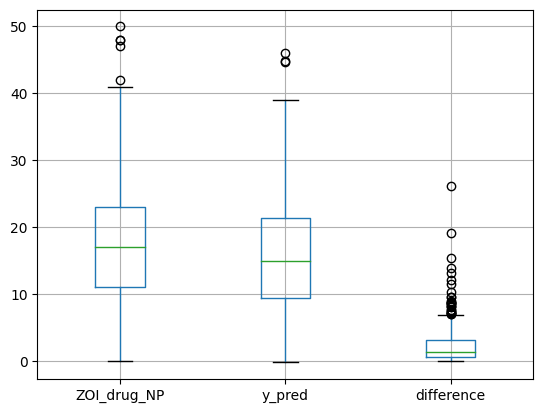

In [25]:
train_an.boxplot()
plt.show()

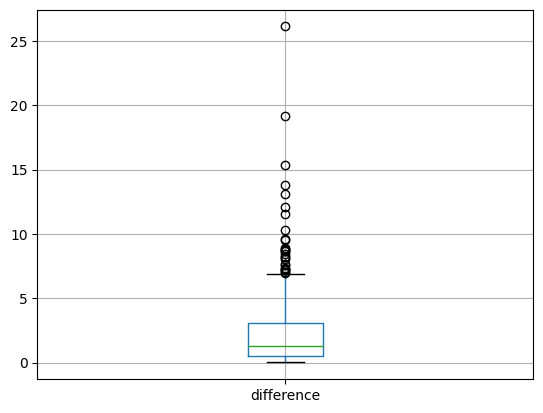

In [26]:
train_an.boxplot('difference')
plt.show()

In [27]:
train_an[train_an['difference']>=5].shape

(55, 3)

In [28]:
shap.initjs()

In [29]:
background = X_train.values[np.random.choice(X_train.shape[0], 100, replace=False)]
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(model_one_targ0, X_train.values)
# compute shap values
shap_values = explainer.shap_values(X_train.values)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [30]:
shap_values = shap_values[0]

In [31]:
shap_values.shape

(356, 14)

In [32]:
shap_values[0]

array([ 1.60504187e-01, -6.10012444e-01,  4.43965562e-01,  3.23011914e+00,
        1.60474554e-01, -9.77101559e-02, -1.09188893e-03,  1.65625248e-02,
       -4.98281845e-03,  3.76387518e-01, -2.75643057e-01,  7.92934937e-02,
        1.81285105e-02,  2.14931501e-02])

In [33]:
X_train

,NP size_min,NP size_max,NP size_avg,ZOI_drug,NumHDonors,NumHAcceptors,MaxAbsPartialCharge,MinAbsPartialCharge,MinPartialCharge,"avg_Incub_period, h","growth_temp, C",shape_nanorods_and_triangles,gram_p,biosafety_level
198,8.0,20.0,13.5,20.00,8.0,12.0,0.387562,0.185232,-0.387562,48.0,37.0,1.0,0,2.0
529,4.0,10.0,8.0,0.25,4.0,6.0,0.507967,0.327399,-0.507967,36.0,37.0,0.0,0,2.0
436,8.0,20.0,13.5,7.00,1.0,5.0,1.000000,0.547832,-0.547832,48.0,37.0,1.0,0,2.0
462,15.0,30.0,28.0,17.00,3.0,11.0,0.543191,0.349825,-0.543191,48.0,37.0,0.0,0,2.0
276,8.0,20.0,13.5,16.00,5.0,14.0,0.458937,0.311188,-0.458937,252.0,37.0,1.0,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,5.0,40.0,13.0,12.00,8.0,12.0,0.387562,0.185232,-0.387562,84.0,37.0,0.0,0,2.0
263,8.0,20.0,13.5,7.00,11.0,15.0,0.393567,0.186623,-0.393567,48.0,30.0,1.0,0,2.0
167,8.0,20.0,13.5,21.00,3.0,5.0,0.394123,0.268945,-0.394123,252.0,37.0,1.0,0,2.0
376,5.0,32.0,22.5,8.00,11.0,15.0,0.393567,0.186623,-0.393567,48.0,37.0,0.0,0,2.0


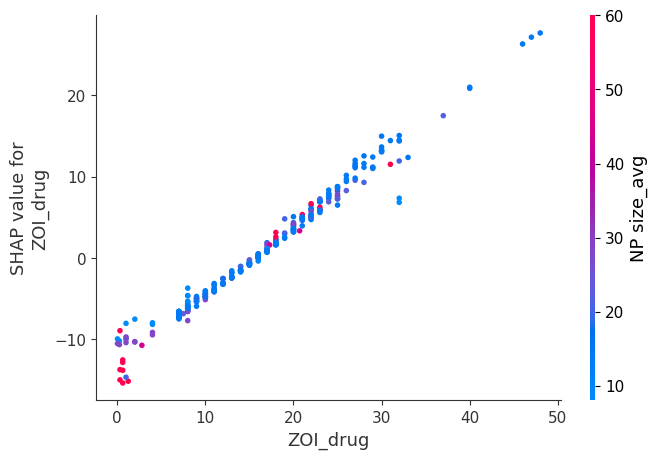

In [34]:
shap.dependence_plot('ZOI_drug', shap_values, X_train)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


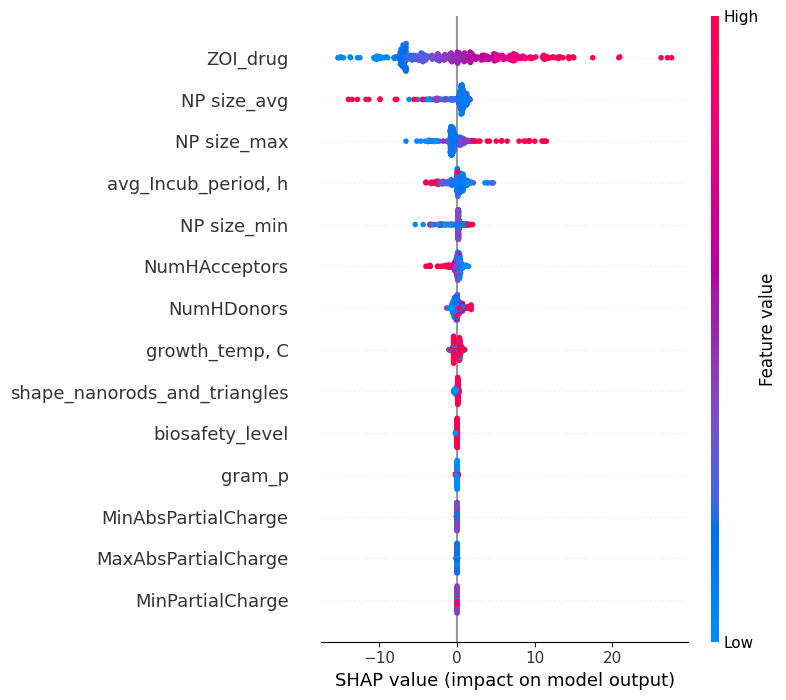

In [35]:
shap.summary_plot(shap_values, X_train)

In [36]:
explainer.expected_value

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([15.523114], dtype=float32)>

In [37]:
expected_value = K.eval(explainer.expected_value[0])
expected_value

15.523114

In [38]:
print('train_an')
print(train_an.iloc[299,:])
shap.force_plot(expected_value, shap_values[0,:], X_train.iloc[299,:])

train_an
ZOI_drug_NP    0.300000
y_pred        -0.147544
difference     0.447544
Name: 299, dtype: float64


In [39]:
print('train_an')
print(train_an.iloc[0,:])
shap.force_plot(expected_value, shap_values[0,:], X_train.iloc[0,:])

train_an
ZOI_drug_NP    20.000000
y_pred         19.040604
difference      0.959396
Name: 0, dtype: float64


In [40]:
NUM_ROWS = 5
shap.force_plot(expected_value, shap_values[0:NUM_ROWS], X_train.iloc[0:NUM_ROWS])

In [41]:
feature_names = X_train.columns


rf_resultX = pd.DataFrame(shap_values, columns = feature_names)

vals = np.abs(rf_resultX.values).mean(0)

shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
shap_importance['feature_importance_vals'] = shap_importance['feature_importance_vals']*10
shap_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
shap_importance

,col_name,feature_importance_vals
3,ZOI_drug,57.873688
2,NP size_avg,12.091559
1,NP size_max,11.316006
9,"avg_Incub_period, h",8.271368
0,NP size_min,5.181358
5,NumHAcceptors,3.780053
4,NumHDonors,3.369535
10,"growth_temp, C",3.183311
11,shape_nanorods_and_triangles,1.274913
13,biosafety_level,0.355156


In [42]:
rf_resultX

,NP size_min,NP size_max,NP size_avg,ZOI_drug,NumHDonors,NumHAcceptors,MaxAbsPartialCharge,MinAbsPartialCharge,MinPartialCharge,"avg_Incub_period, h","growth_temp, C",shape_nanorods_and_triangles,gram_p,biosafety_level
0,0.160504,-0.610012,0.443966,3.230119,0.160475,-0.097710,-0.001092,0.016563,-0.004983,0.376388,-0.275643,0.079293,0.018129,0.021493
1,-0.854761,-2.559161,-0.664490,-10.187536,-0.096771,0.338199,-0.000829,-0.001915,0.003628,-0.644956,-0.483808,-0.080316,0.012993,0.010211
2,0.162519,-0.814080,0.910500,-7.037678,-0.710737,0.171326,-0.004837,-0.034717,0.007203,0.451469,-0.152224,0.120177,0.015249,0.016497
3,-3.433846,-0.965037,-4.516243,1.749261,-0.583609,0.170089,-0.004506,-0.011974,0.011368,0.100755,0.868903,-0.429985,-0.062674,0.036407
4,0.060077,-0.684633,0.716047,0.282599,0.001325,-0.247763,0.004763,-0.000558,-0.000565,-2.855107,0.233444,0.049539,0.049799,0.023301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351,0.368797,0.737128,0.838656,-2.531443,0.319648,0.161832,0.007583,0.023404,-0.006011,-0.450607,0.345654,-0.126695,0.018408,0.019071
352,0.177222,-0.706616,1.130465,-6.642323,0.659786,-0.011799,0.006332,0.024121,-0.008830,0.715857,-0.152645,0.137186,0.013323,0.018618
353,0.066381,-0.673277,0.879338,5.062868,-0.249002,0.710034,0.013222,0.010528,-0.008348,-3.237988,0.295825,0.057295,0.049222,0.023574
354,0.542960,0.393340,0.353312,-6.124665,0.863459,0.236582,0.008637,0.026780,-0.009449,0.628629,0.401508,-0.190412,-0.000750,0.020439


In [43]:
X_train[X_train['ZOI_drug']<= 1]

,NP size_min,NP size_max,NP size_avg,ZOI_drug,NumHDonors,NumHAcceptors,MaxAbsPartialCharge,MinAbsPartialCharge,MinPartialCharge,"avg_Incub_period, h","growth_temp, C",shape_nanorods_and_triangles,gram_p,biosafety_level
529,4.0,10.0,8.0,0.2500,4.0,6.0,0.507967,0.327399,-0.507967,36.0,37.0,0.0,0,2.0
513,5.0,80.0,60.0,0.3125,19.0,25.0,0.507810,0.330441,-0.507810,36.0,37.0,0.0,1,2.0
517,5.0,80.0,60.0,0.6250,2.0,12.0,0.476561,0.352158,-0.476561,48.0,37.0,0.0,0,2.0
532,4.0,10.0,8.0,0.0300,8.0,12.0,0.387562,0.185232,-0.387562,36.0,37.0,0.0,1,2.0
508,15.0,30.0,28.0,1.0000,4.0,6.0,0.507967,0.327399,-0.507967,36.0,37.0,0.0,1,2.0
518,5.0,80.0,60.0,0.6250,1.0,5.0,1.000000,0.547832,-0.547832,84.0,37.0,0.0,0,2.0
504,5.0,80.0,60.0,0.6250,4.0,6.0,0.507967,0.327399,-0.507967,48.0,37.0,0.0,0,2.0
522,15.0,30.0,28.0,0.2500,8.0,12.0,0.387562,0.185232,-0.387562,36.0,37.0,0.0,1,2.0
496,15.0,30.0,28.0,1.0000,8.0,12.0,0.387562,0.185232,-0.387562,48.0,37.0,0.0,0,2.0
524,15.0,30.0,28.0,1.0000,19.0,25.0,0.507810,0.330441,-0.507810,18.0,37.0,0.0,0,2.0


In [ ]:
выводы в 